#**Classification Tasks using Multi-Layer Perceptron**

In [ ]:
!pip install idx2numpy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns


from google.colab import files
from zipfile import ZipFile
import os
import idx2numpy


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

DATASET LINK - https://www.kaggle.com/datasets/hojjatk/mnist-dataset

In [ ]:
# Upload dataset from Kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hojjatk/mnist-dataset

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/hojjatk/mnist-dataset
License(s): copyright-authors
 95% 21.0M/22.0M [00:00<00:00, 105MB/s] 
100% 22.0M/22.0M [00:00<00:00, 96.2MB/s]


In [ ]:
# Extract dataset
with ZipFile("mnist-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("mnist")

The MNIST dataset is in IDX format, which is a special binary format used for storing images and labels

In [ ]:
# Convert to NumPy arrays
train_images = idx2numpy.convert_from_file("/content/mnist/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = idx2numpy.convert_from_file("/content/mnist/train-labels-idx1-ubyte/train-labels-idx1-ubyte")
test_images = idx2numpy.convert_from_file("/content/mnist/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = idx2numpy.convert_from_file("/content/mnist/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [ ]:
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(60000,)


In [ ]:
print(train_images[0][5][12]) #just to check

3


In [ ]:
x_train = train_images.reshape(60000, -1) / 255.0
y_train = train_labels
x_test = test_images.reshape(10000, -1) / 255.0
y_test = test_labels

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_train[0][152]) #this is 3/255

(60000, 784)
(60000,)
0.011764705882352941


**plotting few images**

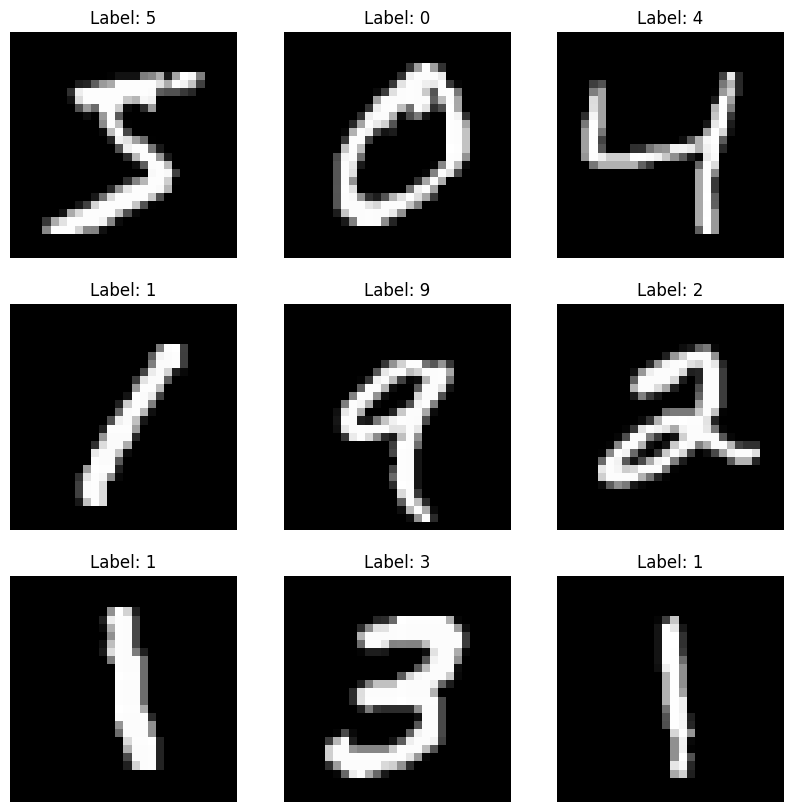

In [ ]:
x_sample = x_train[:9].reshape(-1, 28, 28)  # Reshape from (9, 784) → (9, 28, 28)
y_sample = y_train[:9]

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_sample[i], cmap='gray')  # Ensure grayscale
    plt.title(f"Label: {y_sample[i]}")
    plt.axis('off')
plt.show()


In [ ]:
# One-hot encode the labels
def one_hot_encode(y, num_classes=10):
    encoded = np.zeros((y.shape[0], num_classes))
    encoded[np.arange(y.shape[0]), y] = 1
    return encoded

y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(y_train[0]) #pahla number is 5

(60000, 784)
(60000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# **Model 1**

In [ ]:
# Define MLP model class
class MLP:
    def __init__(self, input_size=784, hidden_size=64, output_size=10, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Initialize weights and biases
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * 0.01
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * 0.01
        self.b2 = np.zeros((1, self.output_size))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def backward(self, X, y):
        m = X.shape[0]
        dz2 = self.a2 - y
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = np.dot(dz2, self.W2.T) * (self.a1 * (1 - self.a1))
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1

    def compute_loss(self, y_pred, y_true): #we use categorical cross entropy loss
        return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))

    def train(self, X, y, epochs=20, batch_size=128):
        losses = []
        for epoch in range(epochs):
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                y_pred = self.forward(X_batch)
                self.backward(X_batch, y_batch)

            loss = self.compute_loss(self.forward(X), y)
            losses.append(loss)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

        return losses

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)


In [ ]:
# Train the model
mlp = MLP()
losses = mlp.train(x_train, y_train, epochs=20)

Epoch 1/20, Loss: 2.2964
Epoch 2/20, Loss: 2.2853
Epoch 3/20, Loss: 2.2540
Epoch 4/20, Loss: 2.1721
Epoch 5/20, Loss: 2.0051
Epoch 6/20, Loss: 1.7663
Epoch 7/20, Loss: 1.5214
Epoch 8/20, Loss: 1.3154
Epoch 9/20, Loss: 1.1543
Epoch 10/20, Loss: 1.0289
Epoch 11/20, Loss: 0.9299
Epoch 12/20, Loss: 0.8503
Epoch 13/20, Loss: 0.7855
Epoch 14/20, Loss: 0.7321
Epoch 15/20, Loss: 0.6875
Epoch 16/20, Loss: 0.6499
Epoch 17/20, Loss: 0.6177
Epoch 18/20, Loss: 0.5899
Epoch 19/20, Loss: 0.5656
Epoch 20/20, Loss: 0.5442


Test Accuracy: 0.8645


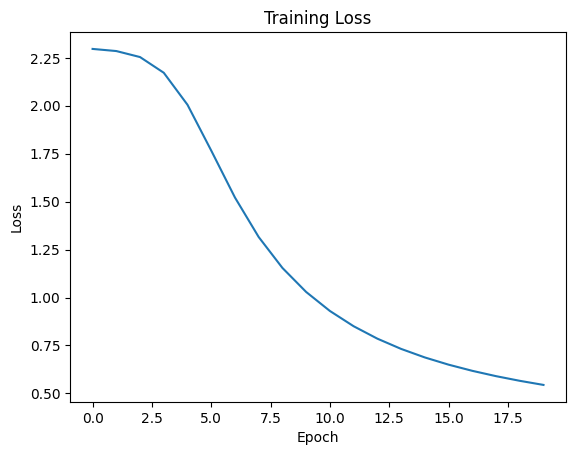

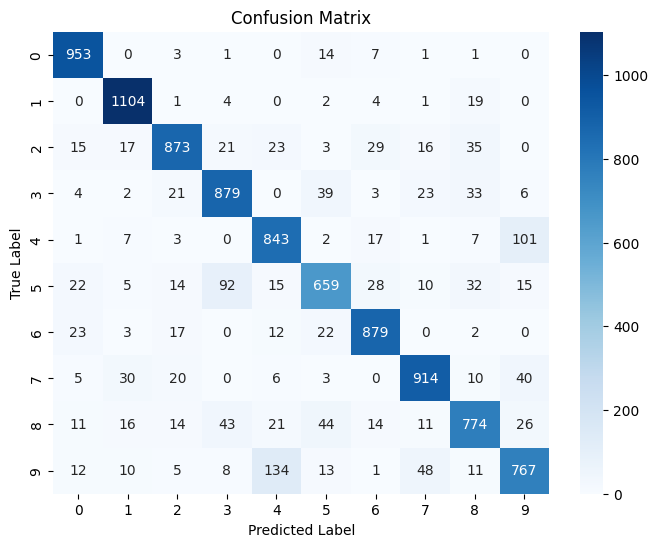

In [ ]:
# Evaluate the model
y_pred = mlp.predict(x_test)
y_true = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred == y_true)
print(f"Test Accuracy: {accuracy:.4f}")

# Plot loss
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

# Computeing confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# **Model 2**

In [ ]:
# Reshape for CNN input (28x28x1) #last 1 is for channels(matlab depth)
x_train2 = x_train.reshape(-1, 28, 28, 1)
x_test2 = x_test.reshape(-1, 28, 28, 1)
y_train2 = y_train
y_test2 = y_test

In [ ]:
print(x_train2.shape)
print(y_train2.shape)
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28, 1)
(60000, 10)
(60000, 784)
(60000, 10)


In [ ]:
# Minimal CNN model (starting with n=1 hidden layer)
cnn_model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile it
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'],run_eagerly=True)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = cnn_model.fit(x_train2, y_train2, epochs=10, validation_data=(x_test2, y_test2), batch_size=64)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 105s 111ms/step - accuracy: 0.8969 - loss: 0.3564 - val_accuracy: 0.9777 - val_loss: 0.0689
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 139s 109ms/step - accuracy: 0.9815 - loss: 0.0628 - val_accuracy: 0.9815 - val_loss: 0.0564
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 100s 107ms/step - accuracy: 0.9885 - loss: 0.0378 - val_accuracy: 0.9863 - val_loss: 0.0422
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 101s 108ms/step - accuracy: 0.9927 - loss: 0.0255 - val_accuracy: 0.9850 - val_loss: 0.0443
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 102s 109ms/step - accuracy: 0.9941 - loss: 0.0181 - val_accuracy: 0.9862 - val_loss: 0.0446
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 139s 106ms/step - accuracy: 0.9957 - loss: 0.0134 - val_accuracy: 0.9855 - val_loss: 0.0491
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 101s 107ms/step - accuracy: 0.9971 - loss: 0.0097 - val_accuracy: 0.9864 - val_loss: 0.0437
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 142s 108ms/step - accuracy: 0.9978 -

In [ ]:
# Evaluate model on test set
test_loss, test_acc = cnn_model.evaluate(x_test2, y_test2)
print(f"Test Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9811 - loss: 0.0725
Test Accuracy: 0.9858


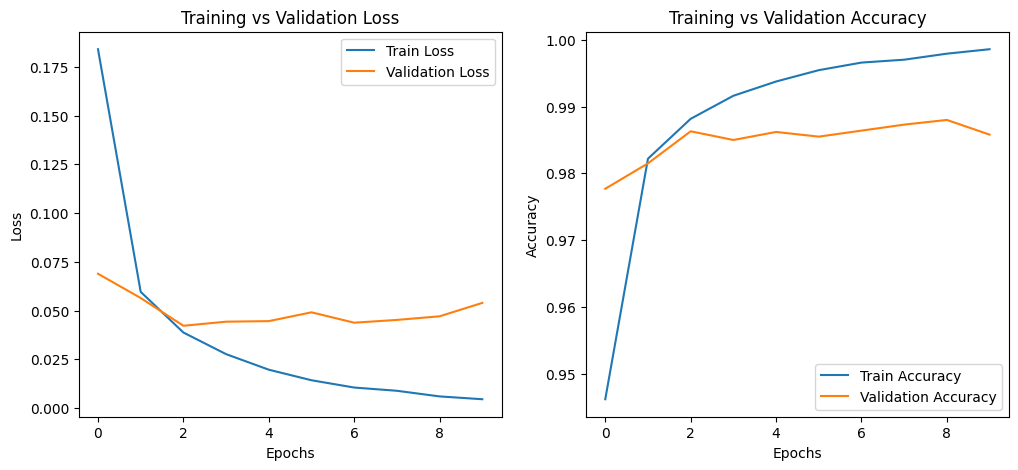

In [ ]:
# Plot training loss and validation loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


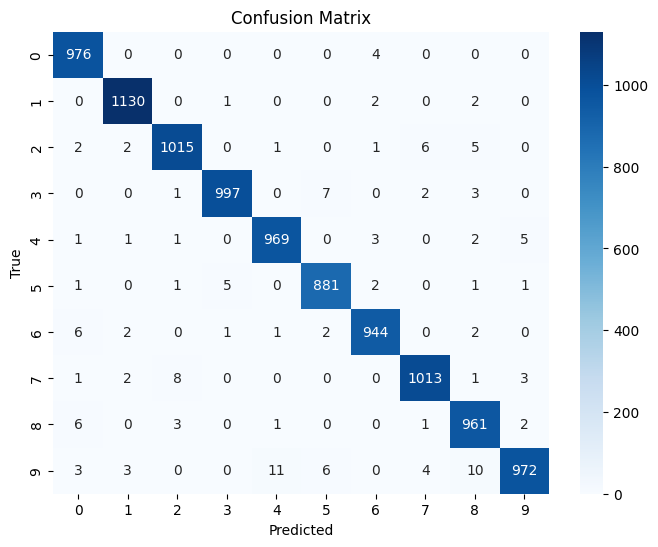

In [ ]:
# Predict on test data
y_pred = cnn_model.predict(x_test2)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


https://colab.research.google.com/drive/1nMcbI8UJmRSAC6MJH-RNjfWE8wBQdvFE#scrollTo=oNYIeEgdrJFV